# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
# data set dimensions
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
## show the first rows 
display(azdias.head(n=10))
display(feat_info.head(n=10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
## see the structure of features
display(azdias.describe())
display(feat_info.describe())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KBA05_ANTG1,person,ordinal,[-1]
freq,1,43,49,26


In [6]:
# checking what type of variables we have 
feat_info.groupby(by="type").size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

In [7]:
# find the number of total missing values 
azdias.isnull().sum().sum()


4896838

In [8]:
# check how many Nans are already in each column
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

f> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
##the missing_or_unknown variable in feature info dataset is a string 
# clean the missing_or_unknown from feat_info
for idx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown'] 
    ## remove the [] and ,
    missing_or_unknown = missing_or_unknown.strip('[') 
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep = ",")
    missing_or_unknown = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in missing_or_unknown]
    
    ### replace the values in azdias with numpy Nans
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[idx]['attribute']: missing_or_unknown} , np.nan) 
        

In [11]:
### total number of missing values
azdias.isnull().sum().sum()

8373929

In [10]:
### being sure if the list of missing_or_unknown variable is replaced by numpy NaN in df
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
## total of missing in each column after converting
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Text(0.5,1,'Probability of missing values in each column')

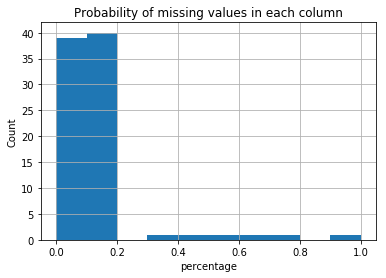

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_columns = azdias.isnull().sum()/azdias.shape[0]
missing_columns.hist()
plt.xlabel('percentage')
plt.ylabel('Count')
plt.title('Probability of missing values in each column')


Text(0.5,1,'Probability of missing values in the columns with less than 20% missing values')

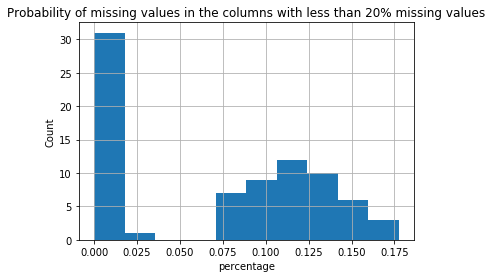

In [14]:
# Investigate patterns in the amount of missing data in each column.
# investigate on the pattern of missing values for the columns with less than 20% missing values

missing_columns_20 = missing_columns[missing_columns < 0.2]
missing_columns_20.hist()
plt.xlabel('percentage')
plt.ylabel('Count')
plt.title('Probability of missing values in the columns with less than 20% missing values')


In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier = missing_columns[missing_columns > 0.2].index
azdias = azdias.drop(outlier,axis=1)
outlier # which variables are outliers 
# remove the feature informations for outliers
feat_info_No_Outlier = feat_info[feat_info.index.isin(outlier) == False]


In [16]:
print(outlier)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [17]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column
The total number of missing values in the dataset is 8373929. Based on the distribution of missing values, there are afew features that caused most of missing values. These features are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and'KBA05_BAUMAX' that have more than 20% missing values overall. These fields might not be mandatory since we have so many missing values in them, so I removed them from the rest of analysis. The distribution of missing values for features with less than 20% has almost normal distribution. And most of them has close to zero missing values that I kept in my analysis, and will be treated in the steps. Then I continue my work with 79 features.    


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
missing_rows = azdias.isnull().sum(axis = 1)
print(missing_rows)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


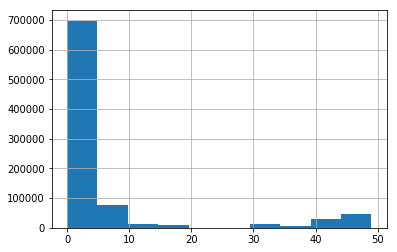

In [19]:
missing_rows = azdias.isnull().sum(axis=1)
missing_rows.hist()

In [20]:
# How much data is missing in each row of the dataset?
azdias_missing_total = azdias.isnull().sum(axis = 1).describe()
print(azdias_missing_total)

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64


In [21]:
# what percentages of rows that are complete
# add a dummay column 
azdias['complete'] = azdias.isnull().sum(axis = 1) == 0
# Count of complete rows
azdias.complete.sum()
# percentage of complete data
azdias.complete.sum()/len(azdias)

0.69927548834688591

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_more_nans = azdias[azdias.isnull().sum(axis=1) > 3].copy()
azdias_less_nans = azdias[azdias.isnull().sum(axis=1) <= 3].copy()

In [23]:
azdias_more_nans.shape

(206719, 80)

In [24]:
azdias_more_nans.isnull().sum(axis=1).sum()

4910827

In [25]:
azdias_less_nans.shape

(684502, 80)

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# list of variables with no missing
azdias_more_nans_no_missing = []
azdias_less_nans_no_missing = []
for idx in range(azdias_more_nans.shape[1]):
    if azdias_more_nans.iloc[:,idx].isnull().sum() == 0:
        azdias_more_nans_no_missing.append(azdias_more_nans.columns[idx])
        
print(azdias_more_nans_no_missing)         


['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP', 'complete']


In [27]:
for idx in range(azdias_less_nans.shape[1]):
    if azdias_less_nans.iloc[:,idx].isnull().sum() == 0:
        azdias_less_nans_no_missing.append(azdias_less_nans.columns[idx])      
        
print(azdias_less_nans_no_missing)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'complete']


In [28]:
### common variables with no missing in both data sets
azdias_common_no_missing = list(set(azdias_more_nans_no_missing).intersection(azdias_less_nans_no_missing))
print(azdias_common_no_missing)

['ZABEOTYP', 'SEMIO_MAT', 'SEMIO_KRIT', 'FINANZ_SPARER', 'SEMIO_ERL', 'SEMIO_KAEM', 'SEMIO_TRADV', 'SEMIO_VERT', 'SEMIO_REL', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'SEMIO_LUST', 'SEMIO_DOM', 'SEMIO_KULT', 'SEMIO_SOZ', 'SEMIO_RAT', 'SEMIO_FAM', 'FINANZTYP', 'GREEN_AVANTGARDE', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_MINIMALIST', 'ANREDE_KZ', 'FINANZ_HAUSBAUER', 'complete', 'SEMIO_PFLICHT']


In [29]:
def barplots(variables):
    len_row = len(variables)
    fig,ax = plt.subplots(figsize=(20,35) , ncols =2 , nrows = len_row , squeeze = False)
    ax[0][0].set_title("Data with Many Missing Values")
    ax[0][1].set_title("Data with Less Missing Values")

    for i in range(len_row):
        sns.countplot(x=variables[i] , data = azdias_more_nans, ax=ax[i][0])
        sns.countplot(x=variables[i] , data = azdias_less_nans , ax=ax[i][1])

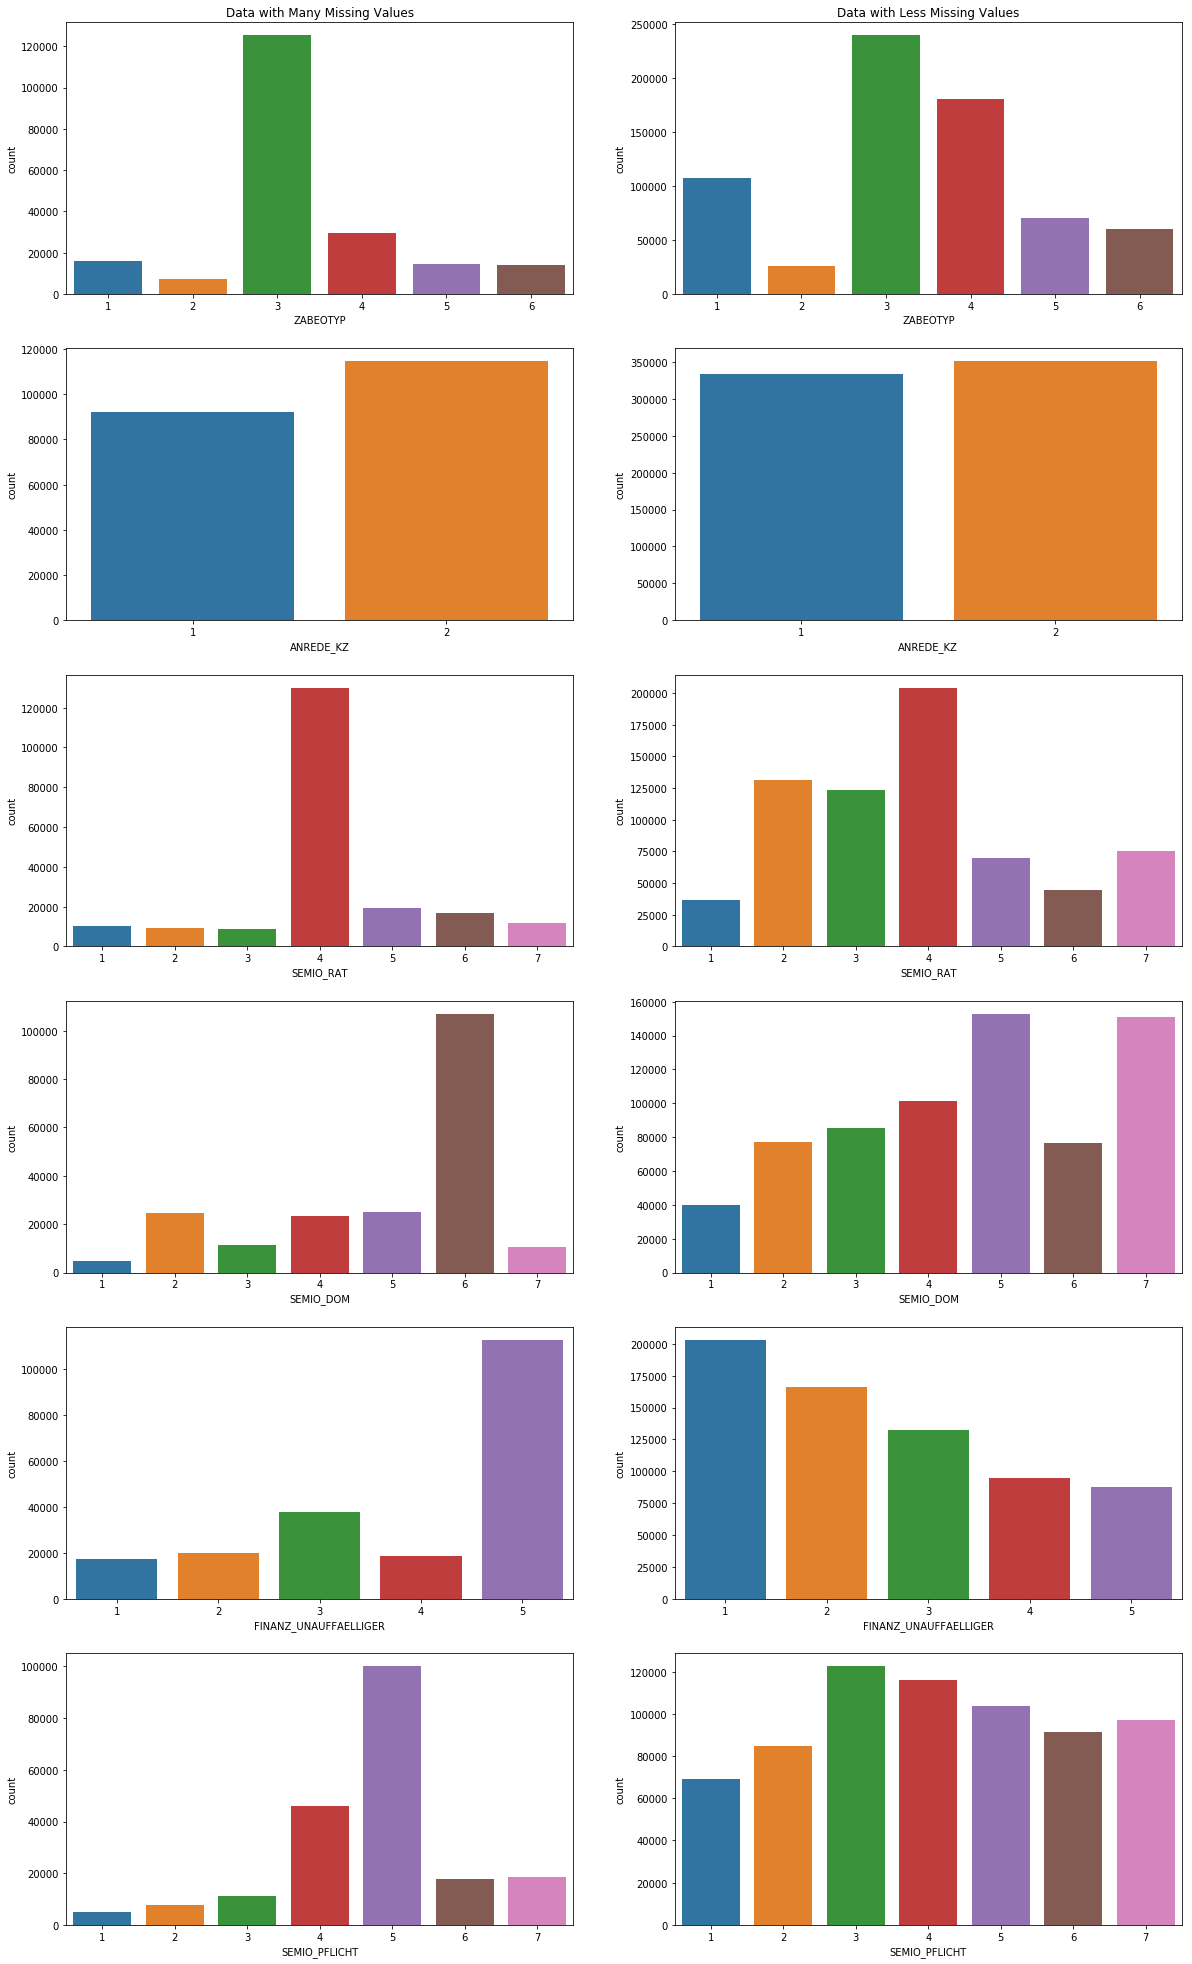

In [127]:
barplots(['ZABEOTYP','ANREDE_KZ','SEMIO_RAT','SEMIO_DOM','FINANZ_UNAUFFAELLIGER','SEMIO_PFLICHT'])


#### Discussion 1.1.3: Assess Missing Data in Each Row

About 70% of rows are complete with no missing values. To assess the distribution of missing rows in the data, I split the data if the missing values for each row is greater than 3 or less , and with in each subset I compared the distribution of nonmissing columns. There are about 24 features that have no missing rows in each subset. It seems to be a difference in the distribution of some demographic features, like 'SEMIO_DOM' ,'FINANZ_UNAUFFAELLIGER' and 'SEMIO_PFLICHT'. And same distribution for 'ANREDE_KZ' and barplots(['ZABEOTYP','ANREDE_KZ','SEMIO_RAT','SEMIO_DOM','FINANZ_UNAUFFAELLIGER','SEMIO_PFLICHT'])
. I decided to continue my analysis on just data with less missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
variabels = list(azdias_less_nans)
feat_info_new =feat_info[feat_info['attribute'].isin(variabels)]
feat_info_new.groupby(by = "type").size()


type
categorical    18
mixed           6
numeric         6
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
categorical_vars = feat_info_new[feat_info_new['type'] == 'categorical'].attribute
binary_vars = []
multi_level_vars=[]

for i in categorical_vars:
    if (len(azdias_less_nans[i].unique())==2):
        binary_vars.append(i)
    elif (len(azdias_less_nans[i].unique())>2):
        multi_level_vars.append(i)
        
        
print('Binary Variables: {}'.format(binary_vars))
print('Multi-level Variables : {}'.format(multi_level_vars))

Binary Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level Variables : ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [32]:
### drop the multi level variables
for i in multi_level_vars:
    azdias_less_nans = azdias_less_nans.drop(i, axis=1)

In [33]:
azdias_less_nans.shape

(684502, 67)

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_less_nans['OST_WEST_KZ_1'] = azdias_less_nans['OST_WEST_KZ']
dummy = {'W' :0 ,'O':1}
azdias_new = azdias_less_nans.replace({'OST_WEST_KZ_1':dummy})
azdias_new.drop(['OST_WEST_KZ'], axis=1 , inplace=True)


In [35]:
azdias_new.shape

(684502, 67)

In [ ]:
## re_Encode the multilevel vars (Not part of this work)
multi_level_vars_df = pd.DataFrame(azdias_less_nans[multi_level_vars], columns = multi_level_vars)
multi_level_vars_df.shape

In [91]:
## check which of this multilevel variables has missing values
multi_level_vars_df.isnull().sum(axis = 0)

CJT_GESAMTTYP          0
FINANZTYP              0
GFK_URLAUBERTYP        0
LP_FAMILIE_FEIN        0
LP_FAMILIE_GROB        0
LP_STATUS_FEIN         0
LP_STATUS_GROB         0
NATIONALITAET_KZ       0
SHOPPER_TYP            0
ZABEOTYP               0
GEBAEUDETYP            0
CAMEO_DEUG_2015     2639
CAMEO_DEU_2015      2639
dtype: int64

In [106]:
## remove the CAMEO_DEUG_2015 and CAMEO_DEU_2015 from analysis because of missing values
multi_level_vars_df_1 = multi_level_vars_df.drop(['CAMEO_DEUG_2015'], axis = 1) 
multi_level_vars_df_2 = multi_level_vars_df_1.drop(['CAMEO_DEU_2015'], axis = 1) 
multi_level_vars_df_2 = multi_level_vars_df_2.astype(str)
## encoding the rest

multi_level_vars_df_3 = pd.get_dummies(multi_level_vars_df_2)
## drop original values
#multi_level_vars_df_encoded = multi_level_vars_df_3.drop(multi_level_vars, axis=1 , inplace=True)
#multi_level_vars_df_3.head
# join with acutal azidas data
azdias_encoded = pd.concat([azdias_less_nans, multi_level_vars_df_3], axis =1)
azdias_encoded.shape

(684502, 150)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are about 18 categorical variables which 5 are binary and 13 are multi levels features. Also, 8 columns that are mixed and intervals. I removed the multi level and mixed variables and encoded the binary ones. I dropped the multilevel ones to speed up the rest of analysis, because in this cas we would have 150 columns. The non_numeric binary variable, OST_WEST_KZ, is replaced with dummy 0 and 1, and the original column is removed from the rest of analysis. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new['decade'] = azdias_new['PRAEGENDE_JUGENDJAHRE']
azdias_new['movement'] = azdias_new['PRAEGENDE_JUGENDJAHRE']
## create a dictionary for the first two dimensions
dec_dict = {1:1 ,2:1 ,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
move_dict = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
# remove original variable from dataset
azdias_new['decade'].replace(dec_dict,inplace=True)
azdias_new['movement'].replace(move_dict,inplace=True)


In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_new['wealth'] = azdias_new['CAMEO_INTL_2015']
azdias_new['life_stage'] = azdias_new['CAMEO_INTL_2015']
wealth_dict = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
life_stage_dict = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
### replace with the values in dictionary 
azdias_new['wealth'].replace(wealth_dict,inplace=True)
azdias_new['life_stage'].replace(life_stage_dict,inplace=True)


In [39]:
# remove mixed variables
## remove mixed vars
mixed_vars = feat_info_new[feat_info_new["type"]=="mixed"]["attribute"]
#print(mixed_vars)
for i in mixed_vars:
    azdias_new.drop(i, axis=1, inplace=True)

In [40]:
azdias_new.shape

(684502, 65)

In [139]:
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,complete,OST_WEST_KZ_1,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,True,0,6.0,1.0,5.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,True,0,6.0,0.0,2.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,True,0,4.0,1.0,4.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,True,0,2.0,1.0,5.0,5.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,5.0,4.0,6.0,3.0,True,0,5.0,1.0,2.0,2.0


In [41]:
### remove complete column from data
del azdias_new ['complete']

#### Discussion 1.2.2: Engineer Mixed-Type Features
I droped the mixed variabels but kept "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015". The values for these two fauture is seperated to two features. For example "PRAEGENDE_JUGENDJAHRE" is split to decade and and the movement associated with, mainstream or avantgarde.  
For these two variables I created two dictionary that maps the values for new features and at the end the old ones are replaced with new ones.   


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
### my lists
outlier = ['GEBURTSJAHR','AGER_TYP', 'ALTER_HH','TITEL_KZ','KK_KUNDENTYP', 'KBA05_BAUMAX']

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[idx]['missing_or_unknown'] # select data by rows
        missing_or_unknown = missing_or_unknown.strip('[') # remove []
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep = ",")
        missing_or_unknown = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in missing_or_unknown]
    
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[idx]['attribute']: missing_or_unknown} , np.nan) ## replace the values in azdia with Nans
        
    outlier = ['GEBURTSJAHR','AGER_TYP', 'ALTER_HH','TITEL_KZ','KK_KUNDENTYP', 'KBA05_BAUMAX']
    # remove selected columns and rows, ...
    df_new = df.drop(outlier , axis=1)
        
    df_new = df_new[df_new.isnull().sum(axis=1) <= 2]
    
    ### update the feat_info
    variabels = list(df_new)
    feat_info_new =feat_info[feat_info['attribute'].isin(variabels)]
    
    # select, re-encode, and engineer column values.
    # df_new ['OST_WEST_KZ_1'] = df_new ['OST_WEST_KZ']
    dummy = {'W' :0 ,'O':1}
    df_new = df_new.replace({'OST_WEST_KZ':dummy})
    # df_new.drop(['OST_WEST_KZ'], axis=1 , inplace=True)
    
    # drop multi level vars
    categorical_vars = feat_info_new[feat_info_new['type'] == 'categorical'].attribute
    multi_level_vars=[]

    for i in categorical_vars:
        if (len(df_new[i].unique())>2):
            multi_level_vars.append(i)
    for j in multi_level_vars:
        df_new=df_new.drop(j, axis=1)
    
    df_new['decade'] = df_new['PRAEGENDE_JUGENDJAHRE']
    df_new['movement'] = df_new['PRAEGENDE_JUGENDJAHRE']
    dec_dict = {1:1 ,2:1 ,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    move_dict = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    # remove original variable from dataset
    df_new['decade'].replace(dec_dict,inplace=True)
    df_new['movement'].replace(move_dict,inplace=True)
    
    df_new['wealth'] = df_new['CAMEO_INTL_2015']
    df_new['life_stage'] = df_new['CAMEO_INTL_2015']
    wealth_dict = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    life_stage_dict = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    ### remove original variable from data
    df_new['wealth'].replace(wealth_dict,inplace=True)
    df_new['life_stage'].replace(life_stage_dict,inplace=True)
    
    ## remove mixed vars
    mixed_vars = feat_info_new[feat_info_new["type"]=="mixed"]["attribute"]
    #print(mixed_vars)
    for i in mixed_vars:
        df_new.drop(i, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_new
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print(f"number of Na's:{ (azdias_new.isnull().sum(axis=1) > 0).sum()}")
print(f"number of Na's:{ azdias_new.isnull().sum().sum()}")

number of Na's:61291
number of Na's:128631


In [44]:
# Apply 'Imputer' to replace missing values with mean
imputer = Imputer()
azdias_new_impute = imputer.fit_transform(azdias_new)

In [45]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform (azdias_new_impute)

### Discussion 2.1: Apply Feature Scaling

I applied all the feature engineeing on the data with few missing values. But, there are still some missing values in the data set, around 128631, and I have to take care of that before going further doing Principal Component Analysis and customer clustering. Instead of removing the rows with missing values, the mean of non missing in each column is imputed for missing values. 
To apply PCA the data has to be scaled around 0 mean and 1 standard deviation.  

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.
# total_components is considered as all the features 

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

In [47]:
pca.explained_variance_ratio_

array([  1.76556244e-01,   1.39662548e-01,   9.57628683e-02,
         5.40851207e-02,   3.79285694e-02,   3.18813204e-02,
         2.81445840e-02,   2.47509113e-02,   2.33943099e-02,
         2.14571986e-02,   2.05939003e-02,   1.92140932e-02,
         1.77299961e-02,   1.74496405e-02,   1.60487480e-02,
         1.56204105e-02,   1.48505625e-02,   1.42966621e-02,
         1.30243099e-02,   1.27282299e-02,   1.22142914e-02,
         1.20830455e-02,   1.12343427e-02,   1.08949926e-02,
         1.04875998e-02,   8.53940095e-03,   7.84407586e-03,
         7.44325539e-03,   7.32095472e-03,   7.18197631e-03,
         6.58440731e-03,   6.52774800e-03,   6.26775216e-03,
         6.18313410e-03,   5.90766914e-03,   5.51990651e-03,
         4.89390528e-03,   4.68610370e-03,   4.42460341e-03,
         4.30606323e-03,   3.94019961e-03,   3.81102637e-03,
         3.69427496e-03,   3.35480529e-03,   3.21556802e-03,
         3.17956929e-03,   3.13603887e-03,   2.90410787e-03,
         2.69994580e-03,

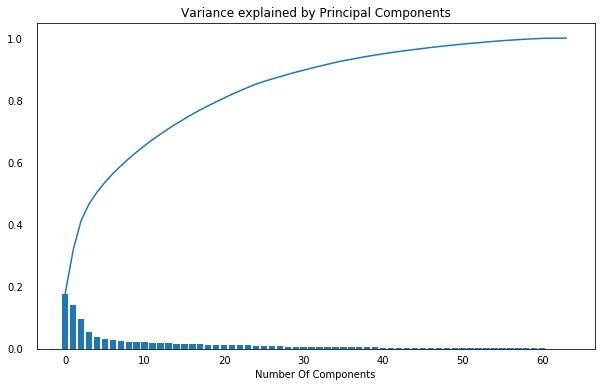

In [48]:
# Investigate the variance accounted for by each principal component.
X = np.arange(azdias_scaled.shape[1])
Y =pca.explained_variance_ratio_
plt.figure(figsize=(10,6))
ax = plt.subplot()
cumvals = np.cumsum(Y)
ax.bar(X,Y)
ax.plot(X,cumvals)
for i in range(azdias_scaled.shape[1]):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0 , length =10)
    plt.title("Variance explained by Principal Components")
    ax.set_xlabel("Number Of Components")


In [49]:
### consider half of the variables
total_components = int(azdias_scaled.shape[1] /2)

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_final = PCA(total_components)
azdias_pca_final = pca_final.fit_transform(azdias_scaled)

In [51]:
sum(pca_final.explained_variance_ratio_)

0.90347169620282353

### Discussion 2.2: Perform Dimensionality Reduction

At the beginning I considered all the features, around 60, as the components. But, after reviwing the variances explained by PCA's I noticed 95% of variances can be explained by half of features in the original data while having less features. So, I applied PCA once more with 32 comonents.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def Interpret_PCA (data , pca):
    dimensions =['Dimension {}'.format(i) for i in range (1,len(pca.components_)+1)]
    
    ## number of pcas
    pca_comp = pca.components_
    components = pd.DataFrame(np.round(pca_comp , 4) , columns = data.columns)
    components.index = dimensions
    
    return(components)


In [53]:
component_dataframe = Interpret_PCA (azdias_new , pca_final)
component_dataframe.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_1,decade,movement,wealth,life_stage
Dimension 1,-0.1160,0.0024,-0.2130,0.1369,-0.1074,0.0599,0.0682,0.1586,-0.1129,0.0265,...,0.0397,-0.1659,0.1433,0.1913,0.1323,0.0584,0.0970,0.1126,0.2121,0.2121
Dimension 2,0.2628,0.0873,0.0709,-0.2384,0.2313,-0.2057,-0.2272,0.1115,-0.0154,-0.0572,...,0.0117,-0.0668,0.0624,0.0821,0.0596,0.0255,-0.2494,0.0131,0.0721,0.0721
Dimension 3,0.0827,-0.3691,0.1591,-0.1023,0.0990,-0.1873,-0.0930,-0.0482,0.0498,-0.0137,...,0.0050,-0.0338,0.0298,0.0426,0.0283,0.0109,-0.1079,-0.0503,0.0241,0.0241
Dimension 4,-0.0401,0.0377,0.0548,-0.0006,-0.0156,-0.1294,0.0879,-0.0965,0.3866,0.0042,...,0.1404,0.0266,0.0490,0.2565,0.0944,-0.1125,0.0368,-0.3860,-0.1329,-0.1329
Dimension 5,0.0020,0.0071,0.0865,-0.0036,-0.0599,0.0424,-0.0473,-0.0869,0.0618,0.0146,...,-0.4902,-0.4042,0.2167,0.0954,0.1481,0.2107,0.0257,-0.0604,-0.0097,-0.0097


In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_dataframe.iloc[0].sort_values(ascending=False)


PLZ8_ANTG3               0.2229
PLZ8_ANTG4               0.2155
life_stage               0.2121
wealth                   0.2121
HH_EINKOMMEN_SCORE       0.2036
ORTSGR_KLS9              0.1913
EWDICHTE                 0.1891
FINANZ_HAUSBAUER         0.1586
KBA05_ANTG4              0.1519
PLZ8_ANTG2               0.1510
ARBEIT                   0.1433
FINANZ_SPARER            0.1369
KBA05_ANTG3              0.1368
ANZ_HAUSHALTE_AKTIV      0.1359
RELAT_AB                 0.1323
movement                 0.1126
SEMIO_PFLICHT            0.1053
SEMIO_REL                0.1020
decade                   0.0970
SEMIO_TRADV              0.0885
SEMIO_RAT                0.0880
SEMIO_MAT                0.0785
SEMIO_FAM                0.0747
REGIOTYP                 0.0731
SEMIO_KULT               0.0689
FINANZ_UNAUFFAELLIGER    0.0682
FINANZ_ANLEGER           0.0599
OST_WEST_KZ_1            0.0584
KKK                      0.0463
SEMIO_SOZ                0.0434
                          ...  
HEALTH_T

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_dataframe.iloc[1].sort_values(ascending=False)


ALTERSKATEGORIE_GROB     0.2628
SEMIO_ERL                0.2334
FINANZ_VORSORGER         0.2313
SEMIO_LUST               0.1842
RETOURTYP_BK_S           0.1645
SEMIO_KRIT               0.1179
W_KEIT_KIND_HH           0.1172
FINANZ_HAUSBAUER         0.1115
SEMIO_KAEM               0.1072
ANREDE_KZ                0.0873
PLZ8_ANTG3               0.0868
EWDICHTE                 0.0834
PLZ8_ANTG4               0.0827
ORTSGR_KLS9              0.0821
wealth                   0.0721
life_stage               0.0721
FINANZ_MINIMALIST        0.0709
KBA05_ANTG4              0.0652
SEMIO_DOM                0.0637
ARBEIT                   0.0624
WOHNDAUER_2008           0.0602
RELAT_AB                 0.0596
PLZ8_ANTG2               0.0592
ANZ_HAUSHALTE_AKTIV      0.0571
HH_EINKOMMEN_SCORE       0.0489
KBA05_ANTG3              0.0424
VERS_TYP                 0.0294
ANZ_HH_TITEL             0.0287
OST_WEST_KZ_1            0.0255
REGIOTYP                 0.0213
                          ...  
SOHO_KZ 

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_dataframe.iloc[2].sort_values(ascending=False)


SEMIO_VERT               0.3486
SEMIO_SOZ                0.2638
SEMIO_FAM                0.2518
SEMIO_KULT               0.2338
FINANZ_MINIMALIST        0.1591
RETOURTYP_BK_S           0.1149
FINANZ_VORSORGER         0.0990
W_KEIT_KIND_HH           0.0918
ALTERSKATEGORIE_GROB     0.0827
SEMIO_REL                0.0808
SEMIO_LUST               0.0739
SEMIO_MAT                0.0528
GREEN_AVANTGARDE         0.0498
EWDICHTE                 0.0428
ORTSGR_KLS9              0.0426
PLZ8_ANTG4               0.0411
PLZ8_ANTG3               0.0406
WOHNDAUER_2008           0.0356
ARBEIT                   0.0298
RELAT_AB                 0.0283
PLZ8_ANTG2               0.0275
KBA05_ANTG4              0.0255
life_stage               0.0241
wealth                   0.0241
ANZ_HAUSHALTE_AKTIV      0.0238
VERS_TYP                 0.0211
ANZ_HH_TITEL             0.0133
OST_WEST_KZ_1            0.0109
ANZ_TITEL                0.0103
KBA05_ANTG3              0.0051
                          ...  
KBA05_AN

### Discussion 2.3: Interpret Principal Components

The first pca is positively correlated with 'PLZ8_ANTG3', number of 6-10 family houses in PLZ8,  'life stage' and 'wealth'. But negatively correlated with the moving pattern by 0.2413 and number of 1-2 family houses in microcell, KBA05_ANTG1.

The second pca represent that this dimension is going to incease by 0.2628 and 0.2334 with one unit incease in ALTERSKATEGORIE_GROB and SEMIO_ERL respectively. ALTERSKATEGORIE_GROB is the estimated age and SEMIO_ERL represents the range of event orriented affinity. Also, this dimension is going to decrease by 0.2649 and 0.2494 with one unit increase in religious, SEMIO_REL, and generation by decade repectively. One unit increase depend on the way SEMIO_REL is topcoded. 

The third component is highly correlated with SEMIO_VERT, dreamful range, positively and ANREDE_KZ, gender, negatively. 

In total, the increase in number of 6-10 family houses in PLZ8 will cause decrease in moving. Also men who dreams less will cause third component to decrease. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
# Over a number of different cluster counts...
sse = []
centers = list(range(1,20))
for i in centers:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i , random_state=123)
    model = kmeans.fit(azdias_pca_final)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca_final))
    sse.append(score)
    

In [156]:
print(sse)

[39579392.010885887, 33709667.981663913, 30655887.19147227, 28858723.574871287, 27590308.346269876, 26462946.589662343, 25449559.988847036, 24699035.983596668, 24179060.189784169, 23635364.742756102, 23302687.165501475, 22664351.539056048, 22395853.762604032, 22138728.596438974, 21860044.602480303, 21366198.625360679, 21410223.167952206, 21072641.82444134, 20716578.426330909]


([<matplotlib.axis.XTick at 0x7f1e03bc79e8>,
 <a list of 20 Text xticklabel objects>)

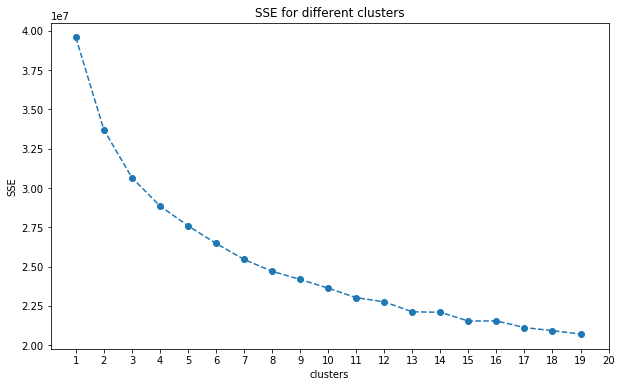

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10,6))
#ax = plt.subplot()
plt.xticks(np.arange(1,21,step=1))
plt.plot(centers,sse, linestyle='--', marker='o');
plt.xlabel('clusters');
plt.ylabel('SSE');
plt.title('SSE for different clusters');
plt.xticks(np.arange(1,21,step=1))



In [130]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 8 , random_state= 123)
azdias_prediction = kmeans.fit_predict(azdias_pca_final)


In [131]:
## cbind the cluster column to the pca data
dimensions =['Dimension {}'.format(i) for i in range (1,len(pca_final.components_)+1)]
cluster_dataframe = pd.DataFrame(np.round(azdias_pca_final,5), columns = dimensions)
cluster_dataframe.insert(loc=0 , column='cluster', value=azdias_prediction)
cluster_dataframe.head()


,cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 23,Dimension 24,Dimension 25,Dimension 26,Dimension 27,Dimension 28,Dimension 29,Dimension 30,Dimension 31,Dimension 32
0,4,3.93602,-2.63969,-2.97455,-0.46337,-2.48319,2.24393,0.93330,1.27050,-0.93711,...,0.01260,-0.57753,-0.76369,0.35236,-0.22911,-0.64954,-0.59079,-0.56077,0.93443,-0.60605
1,3,-1.03291,0.13270,-3.11521,2.28812,-0.91963,-0.16237,-0.93960,0.26373,-1.44490,...,-0.84061,-1.29184,-0.18645,0.31478,-0.79059,1.29535,-0.29339,-0.08425,-0.58961,-0.35070
2,6,0.71789,0.22750,3.23827,0.47708,1.52499,-2.97088,1.99100,0.99724,-0.99105,...,-0.12605,-0.73374,0.18664,0.37869,-0.30222,-0.48303,-0.14014,1.24093,-0.07237,0.02940
3,7,-0.28890,-1.33499,-1.06208,-2.20180,-3.21489,-1.00500,-0.31262,-2.34951,1.61359,...,0.82153,-0.60734,-0.85829,0.13929,1.04651,0.89975,0.62592,0.81213,0.34357,-0.55806
4,7,0.03922,-3.24746,-3.63488,-0.25460,-1.46544,-1.19580,-0.37331,-1.33149,2.39748,...,-1.31422,0.74517,1.23352,0.79096,-0.01804,0.43268,0.07638,0.05784,-0.86943,-0.24402


### Discussion 3.1: Apply Clustering to General Population

The sum of squared errors are captured for different range of clusters, and plotted to find the elbow. As the number of clusters increases the sse decreases. There is no visible elbow, but I decided to segment the customers within 10 clusters since the sse does not decrease from cluster 8 to 9. I also tried other clusters like 9, 10,11 and 12, but it caused one cluster to be overrepresented, close to 99%, and the rest underrepresented.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [62]:
customers_clean = clean_data(customers)
customers_clean.shape

(122116, 64)

In [63]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# deal with NA's
customers_impute = imputer.fit_transform(customers_clean)
customers_scaled = scaler.transform(customers_impute)
customers_pca = pca_final.transform(customers_scaled)
customers_prediction = kmeans.predict(customers_pca)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [132]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_prediction = pd.DataFrame (np.array(kmeans.predict(azdias_pca_final)) , columns =['cluster'])
customer_prediction = pd.DataFrame(np.array(kmeans.predict(customers_pca)), columns = ['cluster'])
### count howmany in each cluster
azdias_each_cluster = azdias_prediction.groupby('cluster').size()
customer_each_cluster = customer_prediction.groupby('cluster').size()
## find the probabilities
azdias_probability = pd.DataFrame(azdias_each_cluster/azdias_each_cluster.sum()).reset_index()
azdias_probability.columns = ['cluster','probability']

customer_probability = pd.DataFrame(customer_each_cluster/customer_each_cluster.sum()).reset_index()
customer_probability.columns = ['cluster','probability']



In [133]:
customer_probability

,cluster,probability
0,0,0.000033
1,2,0.675350
2,3,0.318803
3,5,0.001507
4,6,0.000008
5,7,0.004299


In [134]:
## dataframe that contains the clusters and relevent probabilities in each population
azdias_probability ['target'] = 'population'
azdias_probability.columns = ['cluster' , 'probability' , 'target']
customer_probability ['target'] = 'customers'
azdias_probability.columns = ['cluster' , 'probability' , 'target']

prediction_comparison = pd.concat([azdias_probability , customer_probability])


In [135]:
prediction_comparison

,cluster,probability,target
0,0,0.144629,population
1,1,0.089635,population
2,2,0.170150,population
3,3,0.167526,population
4,4,0.098689,population
5,5,0.087912,population
6,6,0.139662,population
7,7,0.101797,population
0,0,0.000033,customers
1,2,0.675350,customers


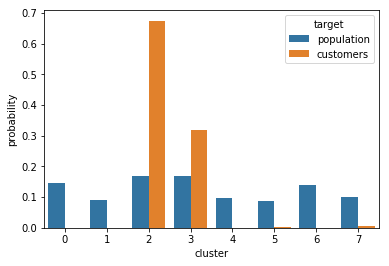

In [136]:
sns.barplot(x='cluster' , y='probability', hue='target' , data = prediction_comparison)

In [137]:
### join the customer pca dataframe with the predicted clusters
customer_pca_cluster = pd.merge(left= pd.DataFrame(customers_pca) , right =customer_prediction , left_index = True , right_index =True)
customer_pca_cluster.head()


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,cluster
0,-276.939073,-102.232183,-45.853371,-71.075955,-35.455258,49.425383,64.334991,-200.488962,16.789496,89.842582,...,68.856610,-33.409526,35.061239,-42.495380,-156.300924,-39.651784,-115.962340,-53.319452,45.687716,2
1,-98.367737,-32.098770,-18.547169,-23.343251,-10.569867,19.276560,21.211460,-70.736650,4.181649,30.314175,...,25.755255,-11.394573,11.701153,-15.409755,-57.362508,-13.203815,-40.755311,-19.154366,16.041542,3
2,-114.274626,-44.560470,-20.061698,-31.598794,-13.568361,22.371686,28.912467,-84.517825,6.780187,38.689113,...,31.010534,-13.849481,16.036673,-17.084627,-67.474718,-15.998332,-50.600101,-21.308436,19.146234,2
3,-266.359935,-98.980701,-45.834671,-69.168717,-31.919402,47.983388,63.576421,-193.460739,15.906919,80.177388,...,66.952397,-33.683916,33.613857,-42.057914,-155.469661,-37.870183,-115.282456,-50.388860,45.394715,2
4,-298.908782,-110.890989,-51.242423,-76.957110,-37.684472,52.598285,70.281761,-217.777936,18.175203,95.622539,...,72.679277,-36.325734,37.889339,-45.528736,-171.075109,-42.804223,-125.674987,-57.228788,50.079847,2


In [169]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
### characteristics of azdias population within cluster = 2 
over_azdias_2 = pca_final.inverse_transform(cluster_dataframe.query('cluster == 2').drop('cluster' , axis =1))
over_azdias_transform_2 = scaler.inverse_transform(over_azdias_2)
over_azdias_transform_2 = pd.DataFrame(over_azdias_transform_2 , columns= azdias_new.columns)
#over_azdias_transform .mean().sort_values()

In [167]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
## characteristics of customer population within cluster = 2
over_customer_2 = pca_final.inverse_transform(customer_pca_cluster.query('cluster == 2').drop('cluster' , axis =1))
over_customer_transform_2 = scaler.inverse_transform(over_customer_2)
over_customer_transform_2  = pd.DataFrame(over_customer_transform_2 , columns= customers_clean.columns)
over_customer_transform_2 .mean().sort_values()


REGIOTYP                -2176.556038
PLZ8_ANTG2               -165.475380
PLZ8_ANTG1               -122.029873
PLZ8_ANTG3               -113.876834
KONSUMNAEHE               -57.944788
PLZ8_ANTG4                -38.277785
wealth                    -25.828005
life_stage                -25.828005
KBA05_GBZ                 -21.878924
RELAT_AB                  -20.681940
KBA05_ANTG4               -18.456905
SEMIO_MAT                 -10.130327
ANZ_PERSONEN               -8.233029
ARBEIT                     -7.476026
W_KEIT_KIND_HH             -6.848413
FINANZ_ANLEGER             -6.832417
BALLRAUM                   -6.763889
KBA05_ANTG1                -5.368443
movement                   -4.753575
FINANZ_MINIMALIST          -3.524923
EWDICHTE                   -3.391261
KKK                        -2.974107
ANZ_HH_TITEL               -2.780612
SEMIO_DOM                  -0.364957
FINANZ_HAUSBAUER           -0.122384
SEMIO_FAM                  -0.087765
KBA05_ANTG3                -0.057802
S

In [170]:
print(over_azdias_transform_2['REGIOTYP'].mean())
print(over_customer_transform_2['REGIOTYP'].mean())

4.09870985223
-2176.55603785


In [171]:
print(over_azdias_transform_2['PLZ8_ANTG2'].mean())
print(over_customer_transform_2['PLZ8_ANTG2'].mean())

2.34411007547
-165.475379967


In [177]:
print(over_azdias_transform_2['PLZ8_ANTG1'].mean())
print(over_customer_transform_2['PLZ8_ANTG1'].mean())

2.90891388697
-122.029873008


In [165]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
### characteristics of azdias population within cluster = 3 
over_azdias_3 = pca_final.inverse_transform(cluster_dataframe.query('cluster == 3').drop('cluster' , axis =1))
over_azdias_transform_3 = scaler.inverse_transform(over_azdias_3)
over_azdias_transform_3  = pd.DataFrame(over_azdias_transform_3 , columns= azdias_new.columns)
#over_azdias_transform .mean()

In [164]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
## characteristics of customer population within cluster = 3
over_customer_3 = pca_final.inverse_transform(customer_pca_cluster.query('cluster == 3').drop('cluster' , axis =1))
over_customer_transform_3 = scaler.inverse_transform(over_customer_3)
over_customer_transform_3 = pd.DataFrame(over_customer_transform_3 , columns= customers_clean.columns)
over_customer_transform_3.mean().sort_values()


REGIOTYP                -2094.419783
PLZ8_ANTG2               -160.028243
PLZ8_ANTG1               -118.181677
PLZ8_ANTG3               -110.043200
KONSUMNAEHE               -56.118437
PLZ8_ANTG4                -36.877424
wealth                    -24.557784
life_stage                -24.557784
KBA05_GBZ                 -21.015372
RELAT_AB                  -19.858312
KBA05_ANTG4               -17.784092
SEMIO_MAT                 -11.102106
ANZ_PERSONEN               -8.345454
ARBEIT                     -6.974004
BALLRAUM                   -6.425347
W_KEIT_KIND_HH             -6.367578
FINANZ_ANLEGER             -5.882832
KBA05_ANTG1                -5.565443
movement                   -4.456666
FINANZ_MINIMALIST          -4.254627
EWDICHTE                   -3.125133
KKK                        -2.871786
ANZ_HH_TITEL               -2.665531
SEMIO_FAM                  -2.627376
SOHO_KZ                     0.018102
KBA05_ANTG3                 0.061369
ANZ_TITEL                   0.201547
S

In [173]:
print(over_azdias_transform_3['REGIOTYP'].mean())
print(over_customer_transform_3['REGIOTYP'].mean())

4.0836214535
-2094.41978283


In [172]:
print(over_azdias_transform_3['PLZ8_ANTG2'].mean())
print(over_customer_transform_3['PLZ8_ANTG2'].mean())

2.36031474057
-160.028242979


In [176]:
print(over_azdias_transform_3['PLZ8_ANTG1'].mean())
print(over_customer_transform_3['PLZ8_ANTG1'].mean())

2.9113277921
-118.181677106


In [166]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
### characteristics of azdias population within cluster =  
under_azdias_6 = pca_final.inverse_transform(cluster_dataframe.query('cluster == 6').drop('cluster' , axis =1))
under_azdias_transform_6 = scaler.inverse_transform(under_azdias_6)
under_azdias_transform_6  = pd.DataFrame(under_azdias_transform_6 , columns= azdias_new.columns)
#under_azdias_transform_6.mean().sort_values()

In [162]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
## characteristics of customer population within cluster = 6
under_customer_6 = pca_final.inverse_transform(customer_pca_cluster.query('cluster == 6').drop('cluster' , axis =1))
under_customer_transform_6 = scaler.inverse_transform(under_customer_6)
under_customer_transform_6  = pd.DataFrame(under_customer_transform_6 , columns= customers_clean.columns)
under_customer_transform_6.mean().sort_values()


REGIOTYP                 -389.833751
PLZ8_ANTG3                 -1.681290
OST_WEST_KZ                -1.044834
PLZ8_ANTG2                 -0.984139
FINANZ_UNAUFFAELLIGER      -0.655698
ANZ_HH_TITEL               -0.029879
movement                   -0.013741
SOHO_KZ                     0.000186
ANZ_TITEL                   0.001764
PLZ8_ANTG4                  0.034233
KBA05_ANTG4                 0.065563
KBA05_ANTG1                 0.224152
KKK                         0.403052
KBA05_ANTG3                 0.668301
FINANZ_SPARER               0.771002
ANZ_PERSONEN                0.812514
GREEN_AVANTGARDE            1.003520
VERS_TYP                    1.017777
ANREDE_KZ                   1.078244
PLZ8_ANTG1                  1.102945
KONSUMNAEHE                 1.431029
RELAT_AB                    1.458480
HEALTH_TYP                  1.733102
FINANZ_ANLEGER              2.014616
SEMIO_RAT                   2.137407
SEMIO_KAEM                  2.235875
BALLRAUM                    2.258503
S

In [163]:
print(under_azdias_transform_6['REGIOTYP'].mean())
print(under_customer_transform_6['REGIOTYP'].mean())

4.84335233361
-389.833751444


In [179]:
print(under_azdias_transform_6['PLZ8_ANTG2'].mean())
print(under_customer_transform_6['PLZ8_ANTG2'].mean())

3.29703392547
-0.984139402121


In [181]:
print(sum(pd.isnull(customers['REGIOTYP'])))
print(sum(pd.isnull(azdias['REGIOTYP'])))

54260
158064


### Discussion 3.3: Compare Customer Data to Demographics Data

Clusters that are overrepresented are cluster 2 and 3. Also, cluster 6 is underrepresented and cluster 1 is not predicted in the customer data. Analayzing the clusters in these two demographics data sets shows that there is a noticable differences in common features like region, number of 3-5 family houses in PLZ8 and customers' wealth. Interestingly same features caused this issue for both over and under representation. 

Comparing the customer data to the population, it appears that the distribution of some features like REGIOTYP , PLZ8_ANTG2 and PLZ8_ANTG3 in these two data sets are different. That might be the reason the clusters did not predicted well. 

For example, the customer's neighborhood typology might be mostly from a special category like upper class than other levels. The second reason is that there is a clear difference in number of missing values in the datasets for these features. Probably the missing values should be treated differently instead of just being removed. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.